In [1]:
import os
import joblib
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMClassifier, early_stopping
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [2]:
# ==========================================
# 1. SETUP SEED (REPRODUCIBILITY)
# ==========================================
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()

print(f"✅ System initialized with Seed: {SEED}")

✅ System initialized with Seed: 42


In [3]:
# ==========================================
# 2. LOAD DATA (PREPROCESSING MILIK FARREL)
# ==========================================
# Path file joblib Farrel
path_joblib = r"C:\Users\BINTANG PANDU\Downloads\split_dataset.joblib"

print(f"📂 Loading data from: {path_joblib}")

try:
    data_dict = joblib.load(path_joblib)
    
    # Asumsi struktur joblib Farrel adalah Dictionary atau List.
    # Sesuaikan indexing di bawah jika struktur Farrel berbeda (misal return tuple langsung)
    if isinstance(data_dict, dict):
        X_train_full = data_dict['X_train']
        X_test = data_dict['X_test']
        y_train_full = data_dict['y_train']
        y_test = data_dict['y_test']
    elif isinstance(data_dict, (list, tuple)):
        X_train_full, X_test, y_train_full, y_test = data_dict
    else:
        raise ValueError("Format Joblib tidak dikenali, harap cek struktur data Farrel.")

    print(f"   Shape X_train_full: {X_train_full.shape}")
    print(f"   Shape X_test: {X_test.shape}")

    # PENTING: LightGBM Anda butuh Validation Set (X_val) untuk early_stopping.
    # Kita pecah X_train_full menjadi X_train dan X_val (misal 80:20)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full, y_train_full, test_size=0.2, random_state=SEED, stratify=y_train_full
    )
    
    print("✅ Data Loaded & Split (Train/Val/Test) Success")

except Exception as e:
    print(f"❌ Error loading data: {e}")
    # Stop execution if data fails to load
    exit()

# Fungsi Helper untuk Evaluasi
def evaluasi_model(y_true, y_pred, y_pred_proba, model_name="Model"):
    print(f"\n{'='*20} {model_name} EVALUATION {'='*20}")
    print(classification_report(y_true, y_pred))
    
    auc = roc_auc_score(y_true, y_pred_proba)
    print(f"🚀 ROC-AUC Score: {auc:.4f}")

    # Plot Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

📂 Loading data from: C:\Users\BINTANG PANDU\Downloads\split_dataset.joblib
   Shape X_train_full: (1764558, 52)
   Shape X_test: (378120, 52)
✅ Data Loaded & Split (Train/Val/Test) Success


In [4]:
# ==========================================
# 3. TEACHER MODEL: LightGBM
# ==========================================
print("\n🔄 Training Teacher Model (LightGBM)...")

lgbm = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    random_state=SEED,
    n_jobs=-1
)

lgbm.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="binary_logloss",
    callbacks=[early_stopping(stopping_rounds=50, verbose=True)]
)

print("✅ Teacher Training Selesai")


🔄 Training Teacher Model (LightGBM)...
[LightGBM] [Info] Number of positive: 238415, number of negative: 1173231
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.157150 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12004
[LightGBM] [Info] Number of data points in the train set: 1411646, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.168891 -> initscore=-1.593504
[LightGBM] [Info] Start training from score -1.593504
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's binary_logloss: 0.00283086
✅ Teacher Training Selesai


c:\Users\BINTANG PANDU\IPS+ML\CICIDS2017---IPSML\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\BINTANG PANDU\IPS+ML\CICIDS2017---IPSML\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



==================== Teacher (LightGBM) EVALUATION ====================
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    314259
           1       1.00      1.00      1.00     63861

    accuracy                           1.00    378120
   macro avg       1.00      1.00      1.00    378120
weighted avg       1.00      1.00      1.00    378120

🚀 ROC-AUC Score: 1.0000


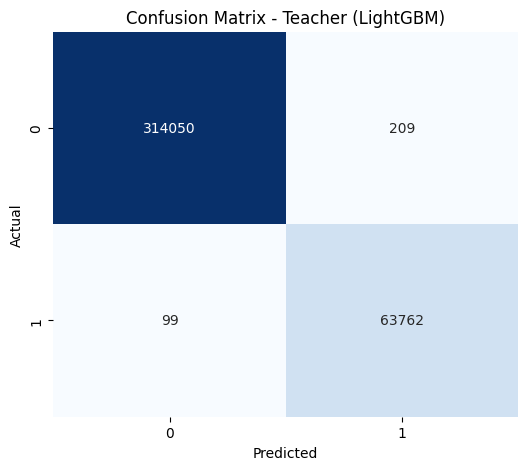

In [5]:
# --- Evaluasi Teacher ---
teacher_pred = lgbm.predict(X_test)
teacher_pred_proba = lgbm.predict_proba(X_test)[:, 1]
evaluasi_model(y_test, teacher_pred, teacher_pred_proba, model_name="Teacher (LightGBM)")

# Distillation 

In [6]:
# ==========================================
# 4. KNOWLEDGE DISTILLATION PREP
# ==========================================
print("\n🧪 Preparing Knowledge Distillation...")

# Generate Soft Labels (Probabilities) dari Teacher
teacher_probs_train = lgbm.predict_proba(X_train)[:,1].astype("float32")
teacher_probs_val   = lgbm.predict_proba(X_val)[:,1].astype("float32")

# Konversi Data ke Numpy Float32 (Wajib untuk TensorFlow/TFLite)
X_train_np = X_train.astype("float32")
if hasattr(X_train, 'to_numpy'): X_train_np = X_train_np.to_numpy()

X_val_np = X_val.astype("float32")
if hasattr(X_val, 'to_numpy'): X_val_np = X_val_np.to_numpy()

X_test_np = X_test.astype("float32")
if hasattr(X_test, 'to_numpy'): X_test_np = X_test_np.to_numpy()

y_train_np = y_train.astype("float32")
if hasattr(y_train, 'to_numpy'): y_train_np = y_train_np.to_numpy()

y_val_np = y_val.astype("float32")
if hasattr(y_val, 'to_numpy'): y_val_np = y_val_np.to_numpy()

# Distillation Parameters
alpha = 0.9   # 90% ikut teacher
T = 2.5       # Temperature

# Softening probabilities
t_train = teacher_probs_train ** (1/T)
t_val   = teacher_probs_val   ** (1/T)

# Campuran Soft Target dan Hard Label
y_train_distill = alpha * t_train + (1 - alpha) * y_train_np
y_val_distill   = alpha * t_val   + (1 - alpha) * y_val_np

print("✅ Soft Targets Created")


🧪 Preparing Knowledge Distillation...


c:\Users\BINTANG PANDU\IPS+ML\CICIDS2017---IPSML\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\BINTANG PANDU\IPS+ML\CICIDS2017---IPSML\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


✅ Soft Targets Created


# Student Model 1 

In [7]:
# ==========================================
# 5. STUDENT MODEL: FNN -- TANPA SCALER & CLASS WEIGHT
# ==========================================
print("\nBuild Student Model (FNN)...")

initializer = tf.keras.initializers.GlorotUniform(seed=SEED)

student = Sequential([
    # Input layer implisit berdasarkan shape data
    Dense(256, activation='relu', kernel_initializer=initializer, input_shape=(X_train_np.shape[1],)),
    Dropout(0.1, seed=SEED),

    Dense(128, activation='relu', kernel_initializer=initializer),
    Dropout(0.1, seed=SEED),

    Dense(64, activation='relu', kernel_initializer=initializer),
    Dense(1, activation='sigmoid', kernel_initializer=initializer)
])

student.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='binary_crossentropy', # Bisa menangani target float (soft labels)
    metrics=['AUC']
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=8,
        restore_best_weights=True, verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5,
        patience=4, verbose=1
    ),
]

print("🔄 Training Student Model...")
history = student.fit(
    X_train_np, y_train_distill,
    validation_data=(X_val_np, y_val_distill),
    epochs=50,
    batch_size=4096,
    verbose=2,
    callbacks=callbacks,
    shuffle=True
)


Build Student Model (FNN)...


c:\Users\BINTANG PANDU\IPS+ML\CICIDS2017---IPSML\venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🔄 Training Student Model...
Epoch 1/50
345/345 - 12s - 35ms/step - AUC: 0.5809 - loss: 19154.3613 - val_AUC: 0.5998 - val_loss: 894.5764 - learning_rate: 1.0000e-03
Epoch 2/50
345/345 - 8s - 23ms/step - AUC: 0.5744 - loss: 1387.6711 - val_AUC: 0.5779 - val_loss: 996.8774 - learning_rate: 1.0000e-03
Epoch 3/50
345/345 - 8s - 24ms/step - AUC: 0.5754 - loss: 816.1564 - val_AUC: 0.5741 - val_loss: 194.1884 - learning_rate: 1.0000e-03
Epoch 4/50
345/345 - 8s - 24ms/step - AUC: 0.5748 - loss: 564.5184 - val_AUC: 0.5705 - val_loss: 567.1147 - learning_rate: 1.0000e-03
Epoch 5/50
345/345 - 9s - 27ms/step - AUC: 0.5801 - loss: 415.1459 - val_AUC: 0.5888 - val_loss: 668.6472 - learning_rate: 1.0000e-03
Epoch 6/50
345/345 - 9s - 26ms/step - AUC: 0.5804 - loss: 394.4133 - val_AUC: 0.6835 - val_loss: 143.7090 - learning_rate: 1.0000e-03
Epoch 7/50
345/345 - 8s - 24ms/step - AUC: 0.5907 - loss: 307.6173 - val_AUC: 0.5788 - val_loss: 108.5817 - learning_rate: 1.0000e-03
Epoch 8/50
345/345 - 9s - 25ms

11817/11817 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step

==================== Student (FNN Distilled) EVALUATION ====================
              precision    recall  f1-score   support

           0       0.86      1.00      0.92    314259
           1       1.00      0.18      0.31     63861

    accuracy                           0.86    378120
   macro avg       0.93      0.59      0.62    378120
weighted avg       0.88      0.86      0.82    378120

🚀 ROC-AUC Score: 0.6720


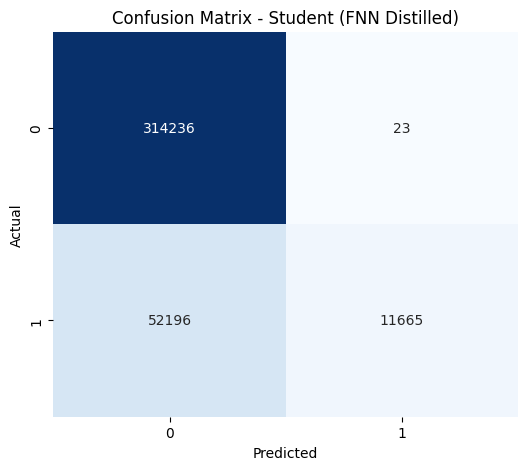

In [8]:
# --- Evaluasi Student ---
# Prediksi Student (Threshold 0.5)
student_pred_proba = student.predict(X_test_np).flatten()
student_pred = (student_pred_proba > 0.5).astype(int)

evaluasi_model(y_test, student_pred, student_pred_proba, model_name="Student (FNN Distilled)")

# Student Model 2


⚖️ Scaling Data for Neural Network (Student)...
✅ Scaler saved. Data normalized.
⚖️ Class Weights: {0: np.float64(0.6016061628102224), 1: np.float64(2.960480674454208)}

Build Student Model (FNN) - Retrying...


c:\Users\BINTANG PANDU\IPS+ML\CICIDS2017---IPSML\venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🔄 Training Student Model with Scaling & Weights...
Epoch 1/50
690/690 - 35s - 50ms/step - AUC: 0.4616 - loss: 0.1026 - val_AUC: 0.5205 - val_loss: 0.0775 - learning_rate: 1.0000e-03
Epoch 2/50
690/690 - 24s - 35ms/step - AUC: 0.5018 - loss: 0.0733 - val_AUC: 0.4278 - val_loss: 0.0863 - learning_rate: 1.0000e-03
Epoch 3/50
690/690 - 23s - 34ms/step - AUC: 0.4910 - loss: 0.0670 - val_AUC: 0.4432 - val_loss: 0.0740 - learning_rate: 1.0000e-03
Epoch 4/50
690/690 - 25s - 36ms/step - AUC: 0.4809 - loss: 0.0633 - val_AUC: 0.3579 - val_loss: 0.0703 - learning_rate: 1.0000e-03
Epoch 5/50
690/690 - 25s - 37ms/step - AUC: 0.4709 - loss: 0.0617 - val_AUC: 0.4245 - val_loss: 0.0700 - learning_rate: 1.0000e-03
Epoch 6/50
690/690 - 25s - 36ms/step - AUC: 0.4881 - loss: 0.0607 - val_AUC: 0.4281 - val_loss: 0.0677 - learning_rate: 1.0000e-03
Epoch 7/50
690/690 - 28s - 40ms/step - AUC: 0.4947 - loss: 0.0598 - val_AUC: 0.4414 - val_loss: 0.0746 - learning_rate: 1.0000e-03
Epoch 8/50
690/690 - 26s - 38ms/

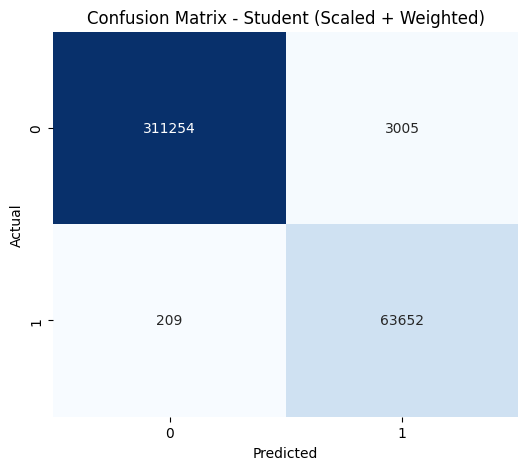

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

# ==========================================
# PERBAIKAN 1: SCALING DATA UNTUK FNN
# ==========================================
print("\n⚖️ Scaling Data for Neural Network (Student)...")

# Kita butuh Scaler terpisah karena LightGBM mungkin tidak pakai scaling
scaler = StandardScaler()

# Fit hanya di TRAIN, lalu transform ke VAL dan TEST
X_train_scaled = scaler.fit_transform(X_train_np)
X_val_scaled   = scaler.transform(X_val_np)
X_test_scaled  = scaler.transform(X_test_np)

# Simpan scaler agar nanti bisa dipakai di deployment/Snort
joblib.dump(scaler, 'scaler_student.joblib')
print("✅ Scaler saved. Data normalized.")

# ==========================================
# PERBAIKAN 2: HITUNG CLASS WEIGHT
# ==========================================
# Ini agar FNN tidak bias ke kelas mayoritas (0)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_np),
    y=y_train_np
)
class_weight_dict = dict(enumerate(class_weights))
print(f"⚖️ Class Weights: {class_weight_dict}")
# Biasanya Class 1 akan punya bobot lebih besar (misal: {0: 0.6, 1: 2.8})

# ==========================================
# 5. STUDENT MODEL: FNN (UPDATED)
# ==========================================
print("\nBuild Student Model (FNN) - Retrying...")

student = Sequential([
    # Input layer sekarang menerima data SCALED
    Dense(512, activation='relu', kernel_initializer=initializer, input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2, seed=SEED), # Naikkan dropout dikit biar robust

    Dense(256, activation='relu', kernel_initializer=initializer),
    Dropout(0.2, seed=SEED),

    Dense(128, activation='relu', kernel_initializer=initializer),
    
    Dense(1, activation='sigmoid', kernel_initializer=initializer)
])

student.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), # Coba learning rate standar dulu
    loss='binary_crossentropy',
    metrics=['AUC']
)

# Callbacks tetap sama
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, verbose=1),
]

print("🔄 Training Student Model with Scaling & Weights...")

history = student.fit(
    X_train_scaled, y_train_distill,       # Gunakan X yang sudah di-SCALE
    validation_data=(X_val_scaled, y_val_distill),
    epochs=50,
    batch_size=2048,                       # Perkecil batch size sedikit agar update bobot lebih sering
    verbose=2,
    callbacks=callbacks,
    shuffle=True,
    class_weight=class_weight_dict         # Masukkan Class Weight di sini
)

# --- Evaluasi Student (Gunakan X_test_scaled) ---
print("\n🔎 Evaluating Improved Student...")
student_pred_proba = student.predict(X_test_scaled).flatten()
student_pred = (student_pred_proba > 0.5).astype(int)

evaluasi_model(y_test, student_pred, student_pred_proba, model_name="Student (Scaled + Weighted)")

In [10]:
# ==========================================
# 6. CONVERT TO TFLITE
# ==========================================
print("\n💾 Converting to TFLite for Snort/Edge Deployment...")

converter = tf.lite.TFLiteConverter.from_keras_model(student)

# Opsi Optimasi (Opsional, untuk ukuran lebih kecil)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()

# Simpan File
tflite_filename = "LNN1.tflite"
with open(tflite_filename, 'wb') as f:
    f.write(tflite_model)

print(f"✅ Model saved as: {tflite_filename}")
print("Selesai! Model siap digunakan di infrastruktur hybrid IPS.")


💾 Converting to TFLite for Snort/Edge Deployment...
INFO:tensorflow:Assets written to: C:\Users\BINTAN~1\AppData\Local\Temp\tmp_tadom2t\assets


INFO:tensorflow:Assets written to: C:\Users\BINTAN~1\AppData\Local\Temp\tmp_tadom2t\assets


Saved artifact at 'C:\Users\BINTAN~1\AppData\Local\Temp\tmp_tadom2t'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 52), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2300380415760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2300380423248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2300380415952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2300380422864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2300380423056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2300380423632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2300380423440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2300380424016: TensorSpec(shape=(), dtype=tf.resource, name=None)
✅ Model saved as: LNN1.tflite
Selesai! Model siap digunakan di infrastruktur hybrid IPS.


# Student Model 3


🏗️ Building Built-in Normalization Layer...
✅ Normalization layer adapted. Mean & Variance stored inside model.
🔄 Training Smart Student (Input: RAW Data)...
Epoch 1/50
690/690 - 31s - 44ms/step - AUC: 0.4592 - loss: 0.1024 - val_AUC: 0.5010 - val_loss: 0.0793 - learning_rate: 1.0000e-03
Epoch 2/50
690/690 - 26s - 37ms/step - AUC: 0.4801 - loss: 0.0731 - val_AUC: 0.4066 - val_loss: 0.0984 - learning_rate: 1.0000e-03
Epoch 3/50
690/690 - 26s - 37ms/step - AUC: 0.4754 - loss: 0.0666 - val_AUC: 0.3934 - val_loss: 0.0696 - learning_rate: 1.0000e-03
Epoch 4/50
690/690 - 26s - 38ms/step - AUC: 0.4570 - loss: 0.0631 - val_AUC: 0.3404 - val_loss: 0.0720 - learning_rate: 1.0000e-03
Epoch 5/50

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
690/690 - 27s - 38ms/step - AUC: 0.4364 - loss: 0.0612 - val_AUC: 0.3804 - val_loss: 0.0828 - learning_rate: 1.0000e-03
Epoch 6/50
690/690 - 24s - 35ms/step - AUC: 0.4253 - loss: 0.0549 - val_AUC: 0.3839 - val_loss: 0.0611 - lear

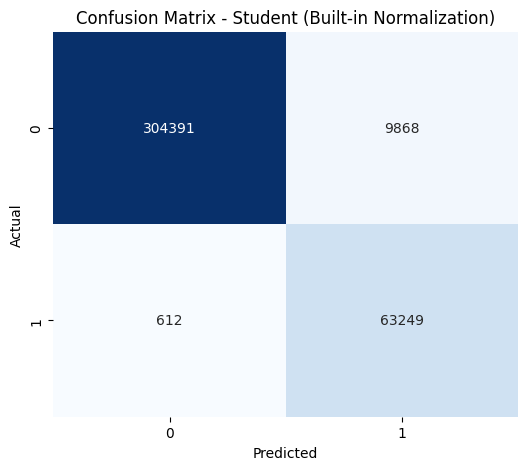


💾 Saving Standalone TFLite...
INFO:tensorflow:Assets written to: C:\Users\BINTAN~1\AppData\Local\Temp\tmpztz5yhy8\assets


INFO:tensorflow:Assets written to: C:\Users\BINTAN~1\AppData\Local\Temp\tmpztz5yhy8\assets


Saved artifact at 'C:\Users\BINTAN~1\AppData\Local\Temp\tmpztz5yhy8'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 52), dtype=tf.float32, name='keras_tensor_14')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2300461831696: TensorSpec(shape=(1, 52), dtype=tf.float32, name=None)
  2301001584272: TensorSpec(shape=(1, 52), dtype=tf.float32, name=None)
  2300461841104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2300461841296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2301001595216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2301001595600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2301001595408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2301001594448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2301001591184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2301001594256: TensorSpec(shape=(), dtype=tf.resource, name=None)
✅ 

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Normalization

# ==========================================
# 1. SETUP NORMALIZATION LAYER (PENGGANTI SCALER)
# ==========================================
print("\n🏗️ Building Built-in Normalization Layer...")

# Layer ini akan menggantikan StandardScaler joblib tadi
# Dia akan hidup di dalam model .tflite
normalizer = Normalization(axis=-1)

# Kita suruh dia "belajar" statistik data (Mean & Std Dev) dari data mentah
# Pastikan X_train_np adalah data MENTAH (bukan yang sudah di-scale manual tadi)
normalizer.adapt(X_train_np)

print("✅ Normalization layer adapted. Mean & Variance stored inside model.")

# ==========================================
# 2. BUILD MODEL (DENGAN NORMALIZER DI DEPAN)
# ==========================================
student_smart = Sequential([
    # Layer 1: Normalizer (Input Raw -> Output Scaled)
    normalizer,
    
    # Layer 2: Hidden Layers (sama seperti yang sukses tadi)
    Dense(512, activation='relu', kernel_initializer=initializer),
    Dropout(0.2, seed=SEED),

    Dense(256, activation='relu', kernel_initializer=initializer),
    Dropout(0.2, seed=SEED),

    Dense(128, activation='relu', kernel_initializer=initializer),
    
    Dense(1, activation='sigmoid', kernel_initializer=initializer)
])

student_smart.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['AUC']
)

# ==========================================
# 3. TRAIN MODEL (PAKAI DATA MENTAH!)
# ==========================================
print("🔄 Training Smart Student (Input: RAW Data)...")

# Perhatikan: Kita input X_train_np (MENTAH), bukan X_train_scaled
# Model akan melakukan scaling sendiri di layer pertama.
history = student_smart.fit(
    X_train_np, y_train_distill,
    validation_data=(X_val_np, y_val_distill),
    epochs=50,
    batch_size=2048,
    verbose=2,
    callbacks=callbacks,
    shuffle=True,
    class_weight=class_weight_dict
)

# ==========================================
# 4. EVALUASI
# ==========================================
# Kita test pakai data mentah juga
print("\n🔎 Evaluating Smart Student...")
student_pred_proba = student_smart.predict(X_test_np).flatten()
student_pred = (student_pred_proba > 0.5).astype(int)

evaluasi_model(y_test, student_pred, student_pred_proba, model_name="Student (Built-in Normalization)")

# ==========================================
# 5. CONVERT TO TFLITE (FINAL)
# ==========================================
print("\n💾 Saving Standalone TFLite...")

converter = tf.lite.TFLiteConverter.from_keras_model(student_smart)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model_smart = converter.convert()

tflite_filename = "standalone.tflite"

with open(tflite_filename, 'wb') as f:
    f.write(tflite_model_smart)

print(f"✅ FILE SIAP: {tflite_filename}")
print("   (File ini bisa langsung terima data mentah dari Snort tanpa scaler luar)")